In [1]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATASET_CSV = ROOT / "data" / "cleaned_dataset.csv"
df = pd.read_csv(DATASET_CSV)
print("rows:", len(df)); df.head()


rows: 60


,audio,speaker_count,language
0,../audios-wav/audios-ar/3_speakers_ar/three_sp...,3 Speakers,ar
1,../audios-wav/audios-en/2_speakers_en/two_spea...,2 Speakers,en
2,../audios-wav/audios-ar/2_speakers_ar/two_spea...,2 Speakers,ar
3,../audios-wav/audios-ar/3_speakers_ar/three_sp...,3 Speakers,ar
4,../audios-wav/audios-en/2_speakers_en/two_spea...,2 Speakers,en


In [2]:
import torch, torchaudio, numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path
import time, re

def to_mono_16k(audio_path: Path):
    wav, sr = torchaudio.load(str(audio_path))          # [C,T]
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0)
    else:
        wav = wav.squeeze(0)
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    return wav, 16000

# MFCC front-end (simple, fast)
mfcc_tf = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=20,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

def feat_mfcc(wav_16k: torch.Tensor) -> np.ndarray:
    with torch.inference_mode():
        mfcc = mfcc_tf(wav_16k.unsqueeze(0))  # [1, n_mfcc, frames]
        mfcc = mfcc.squeeze(0).transpose(0,1) # [frames, n_mfcc]
    return mfcc.cpu().numpy()

def choose_k(embs: np.ndarray, ks=(1,2,3)):
    best_k, best_score = None, -np.inf
    for k in ks:
        if k == 1:
            score = -1e9
        else:
            labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(embs)
            if len(np.unique(labels)) < 2:
                score = -1e9
            else:
                score = float(silhouette_score(embs, labels))
        if score > best_score:
            best_k, best_score = k, score
    if best_k is None:
        best_k = 1
    return int(best_k)

row = df.iloc[0]
audio_path = Path(row["audio"]).resolve()
wav, sr = to_mono_16k(audio_path)
X = feat_mfcc(wav)
k = choose_k(X, ks=(1,2,3))
print(f"Testing: {audio_path.name} | true={row['speaker_count']} | simple_diarizer pred={k} | frames={len(X)}")


Testing: three_speakers7_ar.wav | true=3 Speakers | simple_diarizer pred=2 | frames=29519


In [3]:
import numpy as np, pandas as pd, time, re
from pathlib import Path

RESULTS_DIR = (Path.cwd().parents[0] / "results") if Path.cwd().name == "notebooks" else (Path.cwd() / "results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV_SIMPLE = RESULTS_DIR / "simple_predictions.csv"

def true_count(s):
    m = re.search(r"\d+", str(s))
    return int(m.group()) if m else np.nan

rows, failures = [], 0
t0_all = time.time()

for idx, r in df.iterrows():
    audio_path = Path(r["audio"]).resolve()
    print(f"[{idx+1}/{len(df)}] {audio_path.name} ...", end=" ", flush=True)
    t0 = time.time()
    try:
        wav, sr = to_mono_16k(audio_path)
        X = feat_mfcc(wav)
        pred = choose_k(X, ks=(1,2,3))
        status = f"✓ pred={pred}"
    except Exception as e:
        pred = np.nan
        failures += 1
        status = f"✗ failed ({e})"
    dt = time.time() - t0
    print(f"{status} | {dt:.1f}s")

    rows.append({
        "audio": str(audio_path),
        "language": r["language"],
        "true_speakers": true_count(r["speaker_count"]),
        "pred_speakers": pred,
        "runtime_sec": dt,
    })

simp_df = pd.DataFrame(rows)
simp_df.to_csv(OUT_CSV_SIMPLE, index=False)
print(f"\nSaved: {OUT_CSV_SIMPLE}")
print(f"Total rows: {len(simp_df)} | Failures: {failures} | Total runtime: {(time.time()-t0_all)/60:.1f} min")
simp_df.head(8)


[1/60] three_speakers7_ar.wav ... 

✓ pred=2 | 143.8s
[2/60] two_speakers5_en.wav ... ✓ pred=2 | 99.5s
[3/60] two_speakers7_ar.wav ... ✓ pred=2 | 42.9s
[4/60] three_speakers6_ar.wav ... ✓ pred=2 | 72.9s
[5/60] two_speakers8_en.wav ... ✓ pred=2 | 100.4s
[6/60] solo6_en.wav ... ✓ pred=2 | 40.1s
[7/60] two_speakers9_en.wav ... ✓ pred=2 | 115.7s
[8/60] solo10_en.wav ... ✓ pred=2 | 40.7s
[9/60] two_speakers10_en.wav ... ✓ pred=2 | 133.6s
[10/60] two_speakers1_en.wav ... ✓ pred=2 | 76.4s
[11/60] three_speakers4_en.wav ... ✓ pred=2 | 174.3s
[12/60] two_speakers4_ar.wav ... ✓ pred=2 | 100.0s
[13/60] two_speakers2_ar.wav ... ✓ pred=2 | 125.5s
[14/60] three_speakers6_en.wav ... ✓ pred=2 | 152.4s
[15/60] three_speakers2_en.wav ... ✓ pred=2 | 88.0s
[16/60] solo2_en.wav ... ✓ pred=2 | 44.6s
[17/60] solo8_ar.wav ... ✓ pred=2 | 62.9s
[18/60] solo7_ar.wav ... ✓ pred=2 | 65.4s
[19/60] three_speakers10_en.wav ... ✓ pred=2 | 309.0s
[20/60] solo6_ar.wav ... ✓ pred=2 | 59.8s
[21/60] solo9_ar.wav ... ✓ pred=2 | 82.0s
[22/60] solo8_en.wav ... 

,audio,language,true_speakers,pred_speakers,runtime_sec
0,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,2,143.841778
1,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,99.464288
2,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,2,2,42.944851
3,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,2,72.912346
4,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,100.381716
5,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,1,2,40.068480
6,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,115.671477
7,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,1,2,40.706091


=== SimpleDiarizer Evaluation ===
Accuracy         : 35.00%
Precision (macro): 44.63%
Recall (macro)   : 35.00%
F1-score (macro) : 20.05%

Per-class report:
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        20
           2      0.339     1.000     0.506        20
           3      1.000     0.050     0.095        20

    accuracy                          0.350        60
   macro avg      0.446     0.350     0.201        60
weighted avg      0.446     0.350     0.201        60



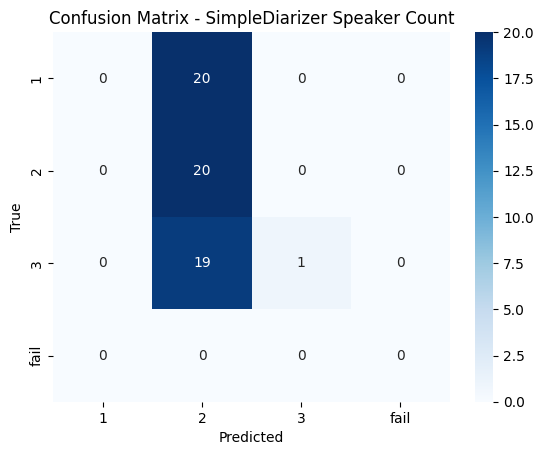

In [4]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from pathlib import Path

RESULTS_DIR = (Path.cwd().parents[0] / "results") if Path.cwd().name == "notebooks" else (Path.cwd() / "results")
OUT_CSV_SIMPLE = RESULTS_DIR / "simple_predictions.csv"

pred_df = pd.read_csv(OUT_CSV_SIMPLE)

y_true = pred_df["true_speakers"].astype(int)
y_pred = pred_df["pred_speakers"].fillna(-1).astype(int)

print("=== SimpleDiarizer Evaluation ===")
print(f"Accuracy         : {accuracy_score(y_true, y_pred):.2%}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro', zero_division=0):.2%}")
print(f"Recall (macro)   : {recall_score(y_true, y_pred, average='macro', zero_division=0):.2%}")
print(f"F1-score (macro) : {f1_score(y_true, y_pred, average='macro', zero_division=0):.2%}\n")
print("Per-class report:")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,-1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,"fail"], yticklabels=[1,2,3,"fail"])
plt.title("Confusion Matrix - SimpleDiarizer Speaker Count")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
